# Importing libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
# Importing sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# Using loaded variables

In [3]:
%run "./../1.Load Codes/1.1 Variables.ipynb"

Loaded variables


# Loading data from previous modules

In [4]:
import pickle

files_data = pickle.load(open(home_path + '/1.Load Codes/files.pickle',"rb"))
acorn_data = files_data['acorn_data']
energy_data = files_data['energy_data']
households_data = files_data['households_data']
weather_data = files_data['weather_data']

# Feature Extraction : Using this technique to outline/extract the Important features for training the model

In [5]:
# Adding all the features of the dataset.

energy_data_ml = energy_data[['LCLid', 'day','energy_sum']]
households_data_ml = households_data[['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped']]
weather_data_ml = weather_data[['temperatureMax', 'windBearing','icon','dewPoint','cloudCover',
 'windSpeed','pressure','precipType','visibility','humidity','apparentTemperatureMax','uvIndex','summary',
 'moonPhase','day']]

In [6]:
energy_data_ml.loc[:,'day']=  pd.to_datetime(energy_data_ml['day']).dt.date

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [7]:
# Combining the three tables i.e energy data , houselhold data and weather data to form a single dataset for feature extraction

combined_ml_dataset = pd.merge(energy_data_ml, households_data_ml, on = 'LCLid')
combined_ml_dataset = pd.merge(combined_ml_dataset, weather_data_ml, on = 'day')
combined_ml_dataset = combined_ml_dataset.head(50000)

In [8]:
# Segregate the data into separate variables so that the features and the labels are separated.

combined_ml_x = combined_ml_dataset.drop(['energy_sum'], axis = 1)
combined_ml_y = combined_ml_dataset['energy_sum']
combined_ml_y = combined_ml_y.astype('int')

In [9]:
# Changing the format for dayOfYear and converting LCLid from string to integer variables.

combined_ml_x['dayOfYear'] = pd.to_datetime(combined_ml_x['day']).dt.dayofyear
combined_ml_x['LCLid'] = combined_ml_dataset['LCLid'].str.findall("\d+").explode().astype(int)

In [10]:
# Converting Categorical values to numerical values using Label Encoder

categories = ['stdorToU', 'Acorn', 'Acorn_grouped','icon','precipType','summary','day']
labelencoder = LabelEncoder()
for i in categories :
    combined_ml_x[i +'_']= labelencoder.fit_transform(combined_ml_x[i])

In [11]:
combined_ml_x.head()

,LCLid,day,stdorToU,Acorn,Acorn_grouped,temperatureMax,windBearing,icon,dewPoint,cloudCover,...,summary,moonPhase,dayOfYear,stdorToU_,Acorn_,Acorn_grouped_,icon_,precipType_,summary_,day_
0,131,2011-12-15,Std,ACORN-E,Affluent,7.97,234,wind,2.41,0.42,...,Partly cloudy throughout the day and breezy in...,0.66,349,0,4,2,4,0,15,0
1,132,2011-12-15,Std,ACORN-E,Affluent,7.97,234,wind,2.41,0.42,...,Partly cloudy throughout the day and breezy in...,0.66,349,0,4,2,4,0,15,0
2,221,2011-12-15,Std,ACORN-E,Affluent,7.97,234,wind,2.41,0.42,...,Partly cloudy throughout the day and breezy in...,0.66,349,0,4,2,4,0,15,0
3,228,2011-12-15,Std,ACORN-E,Affluent,7.97,234,wind,2.41,0.42,...,Partly cloudy throughout the day and breezy in...,0.66,349,0,4,2,4,0,15,0
4,234,2011-12-15,Std,ACORN-E,Affluent,7.97,234,wind,2.41,0.42,...,Partly cloudy throughout the day and breezy in...,0.66,349,0,4,2,4,0,15,0


In [12]:
# Dropping the categorical values 

combined_ml_x = combined_ml_x.drop(categories, axis = 1)
combined_ml_x= combined_ml_x.abs()

In [13]:
# Splitting the dataset in test and train for extracting features from just the training set.

X_train, X_test, y_train, y_test = train_test_split(combined_ml_x, combined_ml_y, test_size=0.20, random_state=42)

In [14]:
X = X_train.values
Y = y_train.values

In [15]:
# Implementing a Chi-Squared statistical test for features to select the best features from the dataset. 

# Using SelectKBest from class scikit-learn library to select a specific number of features.

test = SelectKBest(score_func=chi2, k='all')
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

[8.107e+05 7.240e+02 6.345e+03 3.541e+02 8.917e+00 1.241e+02 1.202e+01
 1.222e+02 1.031e+00 8.721e+02 3.855e+01 2.771e+01 2.420e+04 2.375e+02
 2.713e+03 1.895e+02 4.979e+01 2.285e+02 3.234e+02 2.622e+03]
[[1.300e+02 1.115e+01 2.470e+02 6.440e+00 6.700e-01 3.680e+00 1.025e+03
  1.109e+01 8.500e-01 1.115e+01 1.000e+00 1.800e-01 5.800e+01 0.000e+00
  1.000e+01 1.000e+00 2.000e+00 0.000e+00 1.100e+01 7.400e+01]
 [1.060e+02 1.061e+01 2.840e+02 3.440e+00 5.100e-01 3.420e+00 1.027e+03
  1.326e+01 7.400e-01 1.061e+01 1.000e+00 8.200e-01 4.700e+01 1.000e+00
  1.100e+01 1.000e+00 2.000e+00 0.000e+00 1.600e+01 6.300e+01]
 [4.527e+03 9.370e+00 3.180e+02 1.700e-01 4.800e-01 8.010e+00 1.021e+03
  1.307e+01 6.400e-01 5.560e+00 2.000e+00 4.000e-01 6.500e+01 0.000e+00
  3.000e+00 2.000e+00 4.000e+00 0.000e+00 1.000e+00 8.100e+01]
 [1.010e+02 9.770e+00 2.280e+02 5.170e+00 6.000e-01 2.130e+00 1.019e+03
  7.920e+00 9.500e-01 8.560e+00 1.000e+00 5.000e-02 2.400e+01 0.000e+00
  1.100e+01 1.000e+00 2.000e+00

# Feature Scaling

In [16]:
# Using StandardScaler to scale all the feature values.

scaler = preprocessing.StandardScaler().fit(features)
X_scaled = scaler.transform(X)

In [17]:
# Implementing Recursive Feature Elimination which is a type of wrapper feature selection method by recursively 
# removing attributes and building a model on those attributes that remain.
# Using RFE with the Logistic Regression classifier to rank the features. 

model = LogisticRegression(max_iter=600)
rfe = RFE(model, 1)
fit = rfe.fit(X_scaled, Y)
print("Feature Ranking: %s" % (fit.ranking_))
Selected_features = fit.support_
Feature_Ranking = fit.ranking_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Feature Ranking: [ 2  5 13 14 19 15 10 18  8  6  7  4 20  9  1  3 17 12 16 11]


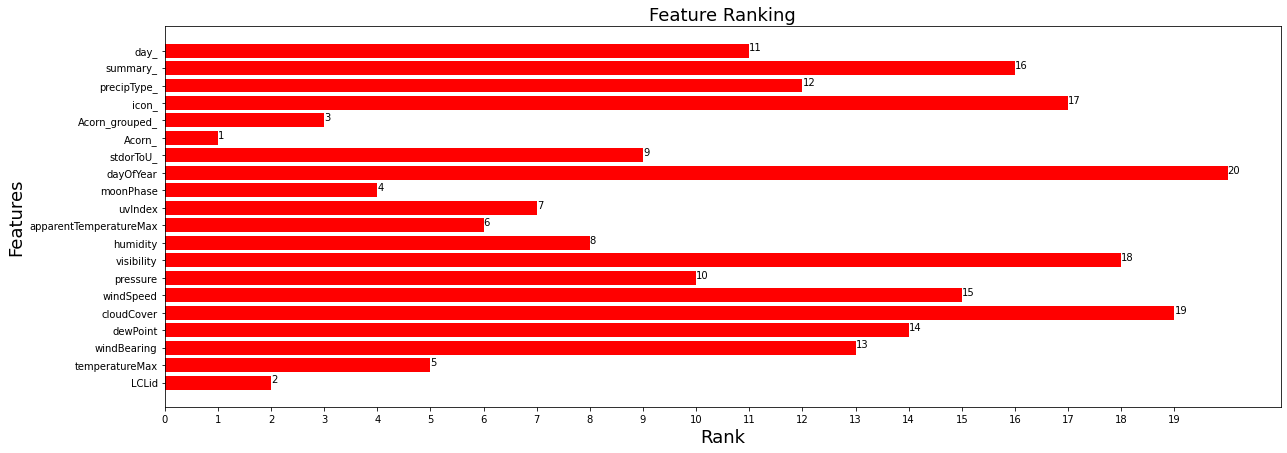

In [18]:
#Ploting all the features using there ranking obtained from above.

Features = list(combined_ml_x)  
fig = plt.figure(figsize = (20, 7))
 
# creating the bar plot
plt.barh(Features, Feature_Ranking, color ='red')

plt.xticks(np.arange(0, max(Feature_Ranking), 1))

for index, value in enumerate(Feature_Ranking):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Rank",fontsize=18)
plt.ylabel("Features",fontsize=18)
plt.title("Feature Ranking",fontsize=18)
plt.show()

In [19]:
#Top 10 Features
Feature_dic = {Features[i]: Feature_Ranking[i] for i in range(len(Features))}
Sorted_features = [(key, value) for (key, value) in sorted(Feature_dic.items(), key=lambda x: x[1])]

for x in list(Sorted_features)[0:10]:
    print (x)


('Acorn_', 1)
('LCLid', 2)
('Acorn_grouped_', 3)
('moonPhase', 4)
('temperatureMax', 5)
('apparentTemperatureMax', 6)
('uvIndex', 7)
('humidity', 8)
('stdorToU_', 9)
('pressure', 10)


# Using these top features to train the model. 

# Getting Dataset variables

In [20]:
# Using these top features. 

energy_data_ml = energy_data[['LCLid','day','energy_sum']]
households_data_ml = households_data[['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped']]
weather_data_ml = weather_data[['moonPhase', 'temperatureMax', 'apparentTemperatureMax', 'uvIndex', 'humidity','pressure','day']]

In [21]:
energy_data_ml.head()

,LCLid,day,energy_sum
0,MAC000131,2011-12-15,9.505
1,MAC000131,2011-12-16,14.216
2,MAC000131,2011-12-17,9.111
3,MAC000131,2011-12-18,10.511
4,MAC000131,2011-12-19,15.647


In [22]:
households_data_ml.head()

,LCLid,stdorToU,Acorn,Acorn_grouped
2,MAC000002,Std,ACORN-A,Affluent
3,MAC003613,Std,ACORN-A,Affluent
4,MAC003597,Std,ACORN-A,Affluent
5,MAC003579,Std,ACORN-A,Affluent
6,MAC003566,Std,ACORN-A,Affluent


In [23]:
weather_data_ml.head()

,moonPhase,temperatureMax,apparentTemperatureMax,uvIndex,humidity,pressure,day
0,0.52,11.96,11.96,1.0,0.95,1016.08,2011-11-11
1,0.53,8.59,5.72,1.0,0.88,1007.71,2011-12-11
2,0.10,10.33,10.33,0.0,0.74,1032.76,2011-12-27
3,0.25,8.07,5.33,1.0,0.87,1012.12,2011-12-02
4,0.99,8.22,5.32,1.0,0.80,1028.17,2011-12-24


In [24]:
energy_data_ml.loc[:,'day']=  pd.to_datetime(energy_data_ml['day']).dt.date

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [25]:
# Combining the three tables i.e energy data , houselhold data and weather data to form a single dataset for feature extraction

combined_ml_dataset = pd.merge(energy_data_ml, households_data_ml, on = 'LCLid')
combined_ml_dataset = pd.merge(combined_ml_dataset, weather_data_ml, on = 'day')
combined_ml_dataset = combined_ml_dataset.head(50000)

In [26]:
combined_ml_dataset.head()

,LCLid,day,energy_sum,stdorToU,Acorn,Acorn_grouped,moonPhase,temperatureMax,apparentTemperatureMax,uvIndex,humidity,pressure
0,MAC000131,2011-12-15,9.505,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75
1,MAC000132,2011-12-15,9.578,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75
2,MAC000221,2011-12-15,21.145,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75
3,MAC000228,2011-12-15,9.778,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75
4,MAC000234,2011-12-15,25.918,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75


In [27]:
# Segregate the data into separate variables so that the features and the labels are separated.

combined_ml_x = combined_ml_dataset.drop(['energy_sum'], axis = 1)
combined_ml_y = combined_ml_dataset['energy_sum']
combined_ml_y = combined_ml_y.astype('int')

In [28]:
combined_ml_x['dayOfYear'] = pd.to_datetime(combined_ml_x['day']).dt.dayofyear

# Converting Strings to numerical values

In [29]:
combined_ml_x['LCLid'] = combined_ml_dataset['LCLid'].str.findall("\d+").explode().astype(int)

# Encoding Labeled Class Columns to Numeric Values

In [30]:
categories = ['stdorToU', 'Acorn', 'Acorn_grouped','day']
labelencoder = LabelEncoder()
for i in categories :
    combined_ml_x[i +'_']= labelencoder.fit_transform(combined_ml_x[i])

In [31]:
combined_ml_x.head()

,LCLid,day,stdorToU,Acorn,Acorn_grouped,moonPhase,temperatureMax,apparentTemperatureMax,uvIndex,humidity,pressure,dayOfYear,stdorToU_,Acorn_,Acorn_grouped_,day_
0,131,2011-12-15,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
1,132,2011-12-15,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
2,221,2011-12-15,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
3,228,2011-12-15,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
4,234,2011-12-15,Std,ACORN-E,Affluent,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0


In [32]:
combined_ml_x = combined_ml_x.drop(categories, axis = 1)

In [33]:
combined_ml_x

,LCLid,moonPhase,temperatureMax,apparentTemperatureMax,uvIndex,humidity,pressure,dayOfYear,stdorToU_,Acorn_,Acorn_grouped_,day_
0,131,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
1,132,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
2,221,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
3,228,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
4,234,0.66,7.97,4.38,1.0,0.77,996.75,349,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4533,0.58,15.39,15.39,2.0,0.81,1036.42,70,0,16,1,86
49996,4540,0.58,15.39,15.39,2.0,0.81,1036.42,70,0,16,1,86
49997,4541,0.58,15.39,15.39,2.0,0.81,1036.42,70,0,16,1,86
49998,4544,0.58,15.39,15.39,2.0,0.81,1036.42,70,0,16,1,86


In [34]:
combined_ml_y.head()

0     9
1     9
2    21
3     9
4    25
Name: energy_sum, dtype: int64

# Train Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(combined_ml_x, combined_ml_y, test_size=0.20, random_state=42)

# Linear Regression

In [36]:
# Performing Linear Regression using selected variables

In [37]:
reg = LinearRegression()
model1= reg.fit(X_train, y_train)
y_hat_test = model1.predict(X_test)
# Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
# Mean Absolute Error
test_mae_LR = mean_absolute_error(y_test, y_hat_test)
print(test_mae_LR)

7.687153692467311


In [38]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lr_score = cross_val_score(model1, X_train, y_train, cv=cv, scoring='r2').mean()

# KNN Regression

In [39]:
n = 5

In [40]:
neigh = KNeighborsRegressor(n_neighbors=n)
model2= neigh.fit(X_train, y_train)
y_hat_test = model2.predict(X_test)
# Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
# Mean Absolute Error
test_mae_KNN_Reg = mean_absolute_error(y_test, y_hat_test)
print(test_mae_KNN_Reg)

7.20822


In [41]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
knn_reg_score = cross_val_score(model2, X_train, y_train, cv=cv, scoring='r2').mean()

# KNN Classification

In [42]:
from sklearn.neighbors import KNeighborsClassifier
KNN_C = KNeighborsClassifier(n_neighbors=n)
model3= KNN_C.fit(X_train, y_train)
y_hat_test = model3.predict(X_test)
# Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
# Mean Absolute Error
test_mae_KNN_Class = mean_absolute_error(y_test, y_hat_test)
print(test_mae_KNN_Class)

8.2378


In [43]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
knn_class_score = cross_val_score(model3, X_train, y_train, cv=cv, scoring='r2').mean()

# Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
# fit the model with the training data
model4=GNB.fit(X_train, y_train)
y_hat_test = model4.predict(X_test)
# Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
# Mean Absolute Error
test_mae_GNB = mean_absolute_error(y_test, y_hat_test)
print(test_mae_GNB)

35.0398


In [45]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
Naive_score = cross_val_score(model4, X_train, y_train, cv=cv, scoring='r2').mean()

# Ridge Regression

In [46]:
Ridge_reg = Ridge(alpha=1.0)
model5 = Ridge_reg.fit(X_train, y_train)
y_hat_test = model5.predict(X_test)
# Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)
# Mean Absolute Error
test_mae_RR = mean_absolute_error(y_test, y_hat_test)
print(test_mae_RR)

7.687155778092921


In [47]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
Ridge_reg_score = cross_val_score(model5, X_train, y_train, cv=cv, scoring='r2').mean()

# Plotting MAE for all the Models for comparision

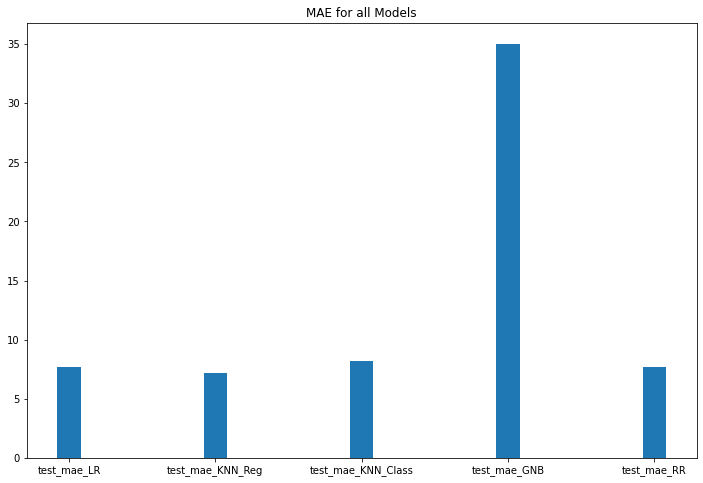

In [48]:
f = plt.figure(figsize=(12, 8))
a = plt.axes()
 
col = [test_mae_LR, test_mae_KNN_Reg, test_mae_KNN_Class, test_mae_GNB, test_mae_RR]
 
MAE = [10, 15, 20, 25, 30]
 
# labels for bars
tick_label = ['test_mae_LR', 'test_mae_KNN_Reg', 'test_mae_KNN_Class', 'test_mae_GNB', 'test_mae_RR']
 
# plotting a bar chart
a.bar(MAE, col, tick_label = tick_label)
 
# plot title
plt.title('MAE for all Models')
 
# function to show the plot
plt.show()

Observations :
    
    1. MAE can range from 0 to infinity and these are negatively-oriented scores. The lower values of MAE are better. 
    
    2. It can be seen that the MAE for KNN regression is the lowest of all the other models which means the model has better efficiency to predict accurate results. This also means that the model is better in comprison to other models and is robust to the effects of outliers. The model has highest tendency to make predictions that matches the expected values exactly bringing stability and more efficiency.
    

# Selecting best model

In [49]:
best_model = reg.fit(X_train, y_train) if(lr_score > (knn_reg_score and knn_class_score and Naive_score and Ridge_reg_score)) else neigh.fit(X_train, y_train)  if(knn_reg_score > (lr_score and knn_class_score and Naive_score and Ridge_reg_score)) else KNN_C.fit(X_train, y_train)  if(knn_class_score > (lr_score and knn_reg_score and Naive_score and Ridge_reg_score)) else GNB.fit(X_train, y_train)  if(Naive_score > (lr_score and knn_class_score and knn_reg_score and Ridge_reg_score)) else Ridge_reg.fit(X_train, y_train)       

In [50]:
best_model 

KNeighborsRegressor()

# Export training data and models

In [52]:
import pickle

model_data = {
    'test_data': X_test,
    'test_targets': y_test,
    'best_model': best_model
}
save_path = open("model.pickle","wb")
pickle.dump(model_data, save_path)